In [117]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.xarray
%matplotlib inline

# Centre Voltage Sweep

In [118]:
cen_v= pd.read_csv('./2019-06-29/test_daedalus_voltCenter_calib_2019-06-29_4.csv', comment="#")

In [125]:
cen_v[abs(cen_v.Yfield-0.1)<0.001]

,V,Xfield,Yfield,Zfield,elapsed_time
320,-1.677856,0.000096,0.100753,-0.000246,162.532296


In [126]:
cen_vp = cen_v[cen_v.Yfield>0]
cen_vn = cen_v[cen_v.Yfield<0]

In [140]:
cen_vp_coeff = np.polyfit(cen_vp.Yfield.values, cen_vp.V.values, 7)
cen_vn_coeff = np.polyfit(cen_vn.Yfield.values, cen_vn.V.values, 7)
cen_v_coeffs = np.asarray([cen_vp_coeff, cen_vn_coeff])
print(cen_v_coeffs)

[[-2.59782317e+05  2.78158269e+05 -1.10992149e+05  1.99167955e+04
  -1.70981837e+03  6.64785570e+01 -1.96614627e+01  2.25431334e-01]
 [ 3.30498291e+03  7.78397270e+03  1.16128804e+04  6.33555065e+03
   1.20961858e+03  9.18797201e+01 -1.61873307e+01  2.30544346e-01]]


In [141]:
np.savetxt("./icarusCalibCsv/icarus_volt_center_calib.csv", cen_v_coeffs, delimiter=",")

In [142]:
cen_vp_fit = np.poly1d(cen_vp_coeff)
cen_vn_fit = np.poly1d(cen_vn_coeff)

In [143]:
cen_vp_fit(0.1)

-1.6518096314988615

Text(0.5, 1.0, 'B(V)')

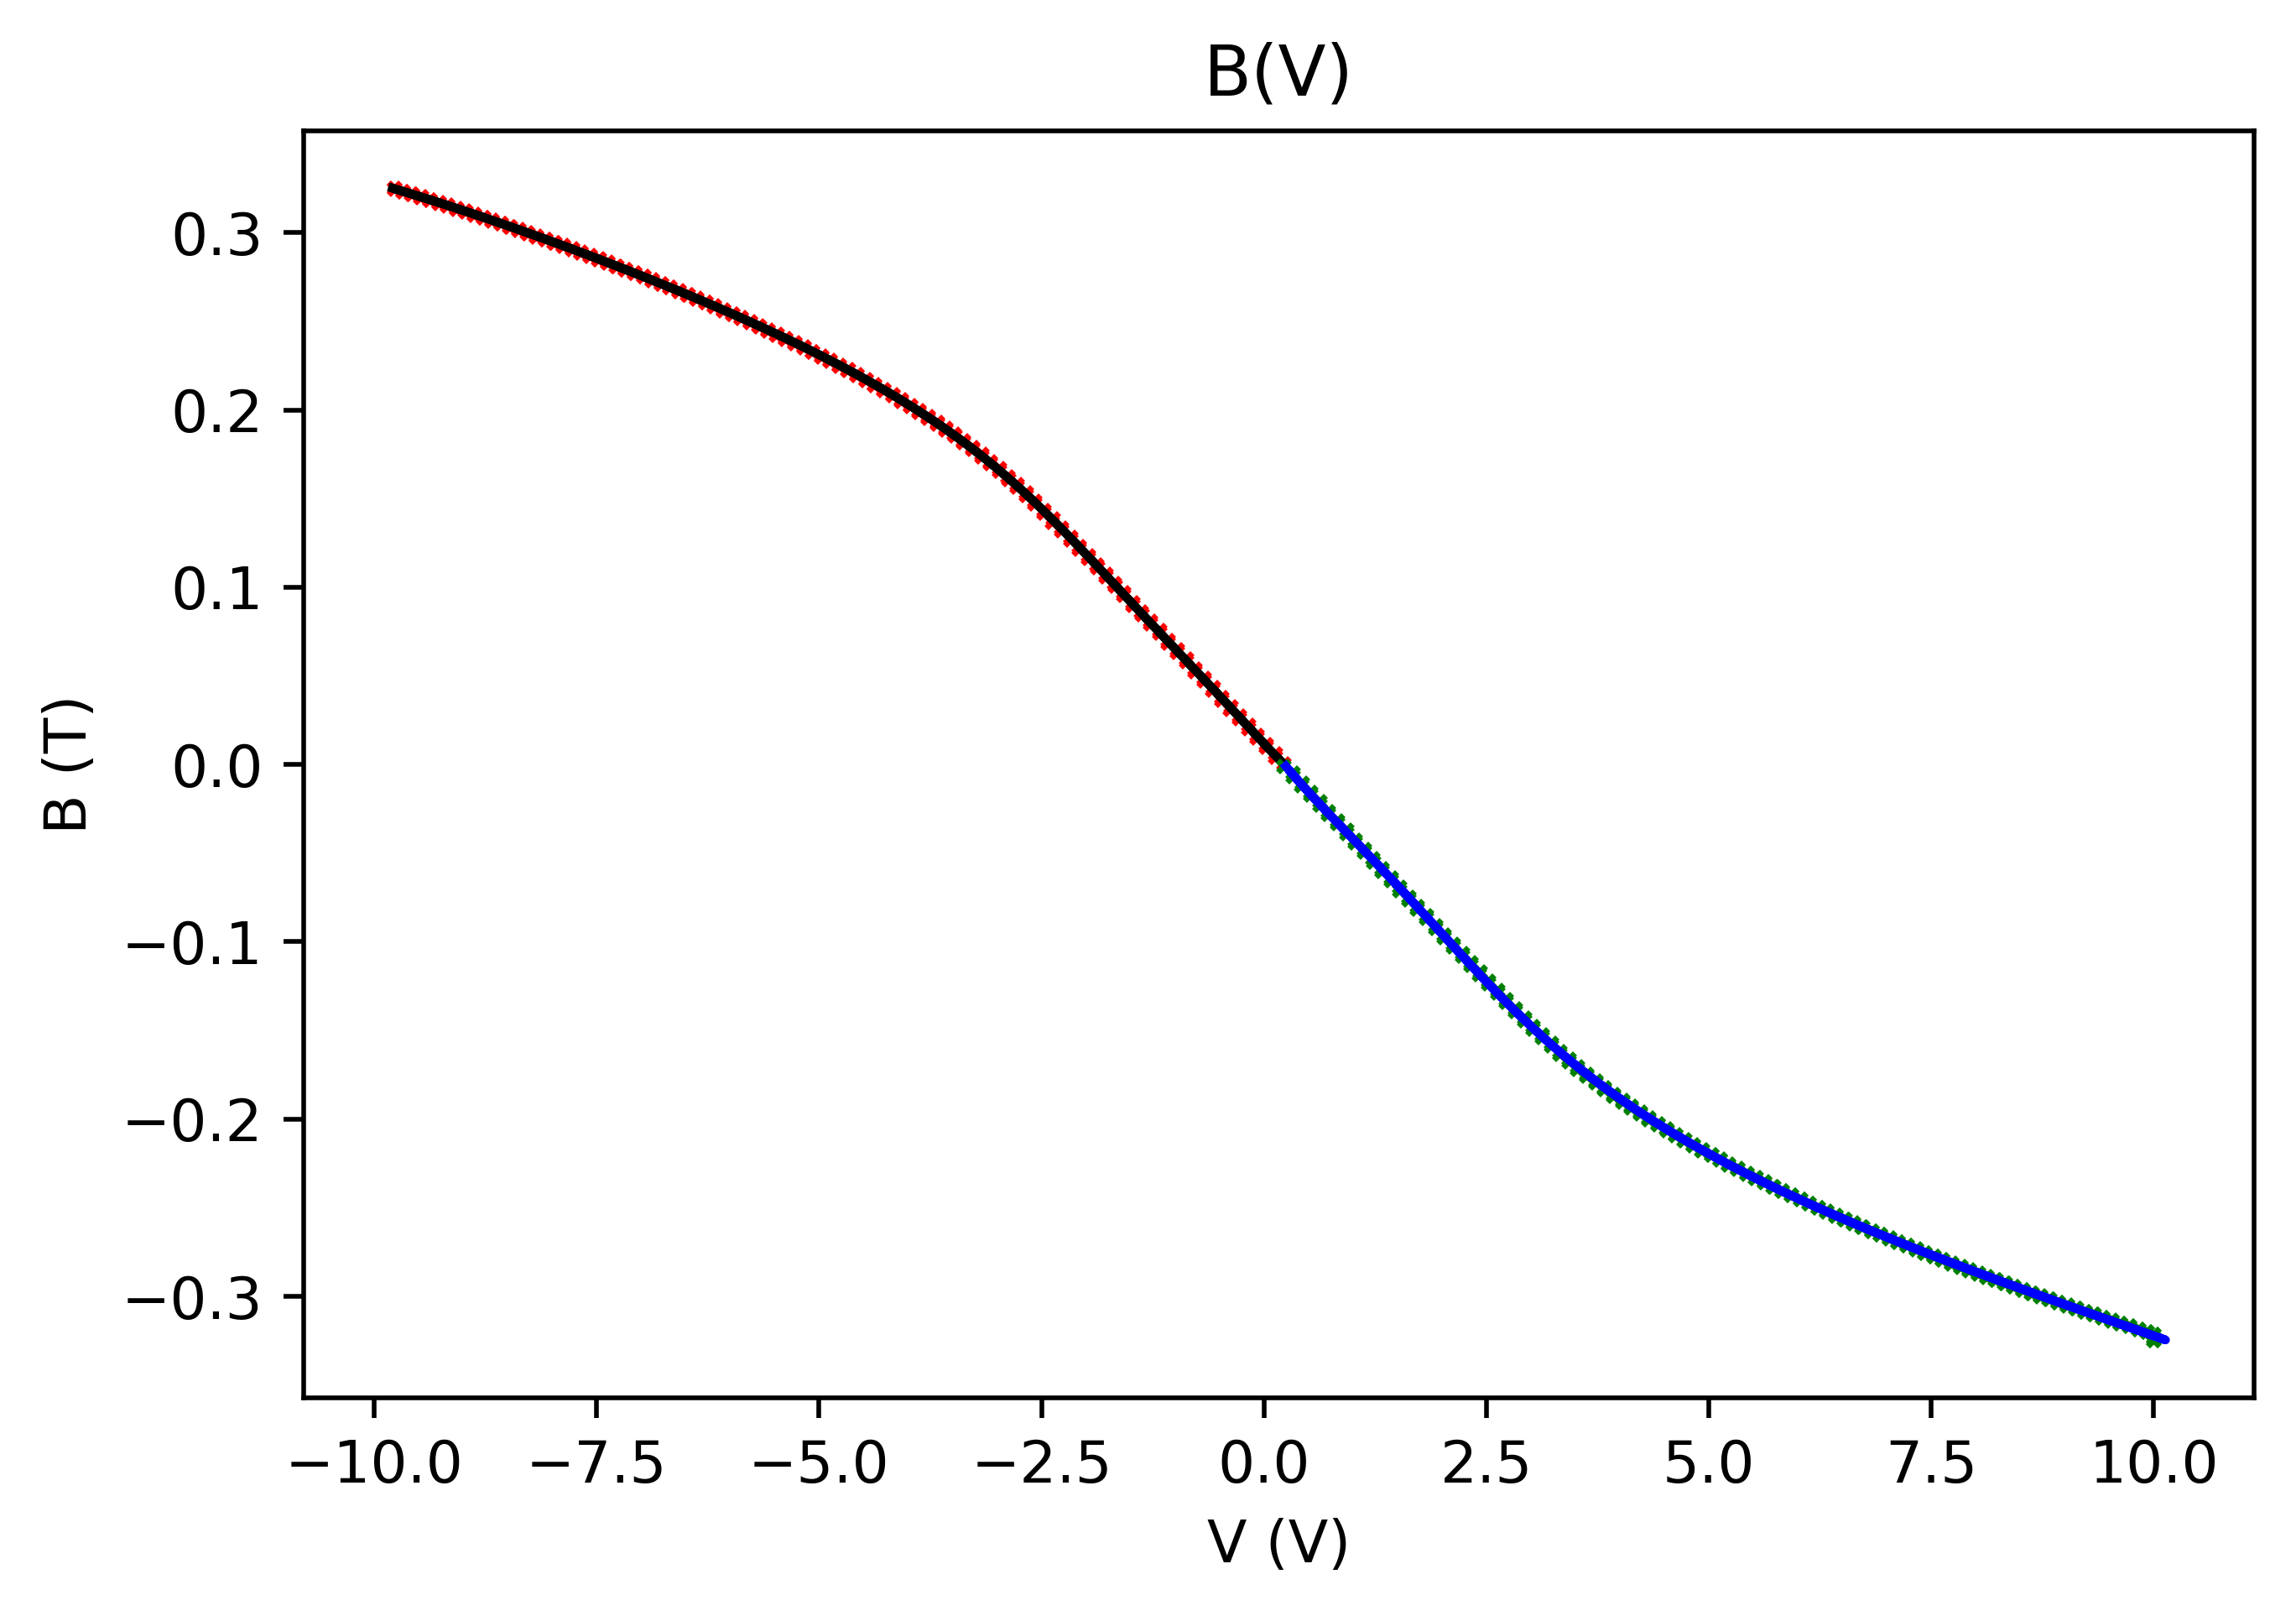

In [144]:
plt.figure(dpi=500)

plt.plot(cen_vp.V, cen_vp.Yfield, 'rx', markersize=2)
plt.plot(cen_vp_fit(cen_vp.Yfield), cen_vp.Yfield , 'k')

plt.plot(cen_vn.V, cen_vn.Yfield, 'gx', markersize=2)
plt.plot(cen_vn_fit(cen_vn.Yfield), cen_vn.Yfield , 'b')
plt.xlabel('V (V)')
plt.ylabel('B (T)')
plt.title('B(V)')

# Radial Calibration 5 V

In [8]:
vp = pd.read_csv('./2019-06-28/5vp_daedalus_radialPolar_calib_A000.0_2019-06-28_2.csv', comment='#')
vn = pd.read_csv('./2019-06-28/5vn_daedalus_radialPolar_calib_A000.0_2019-06-28_1.csv', comment='#')

In [9]:
vp = vp.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp = vp.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Yfield)*180/np.pi)
vp = vp.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

vn = vn.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn = vn.assign(theta=lambda a: np.arctan2(a.Zfield, a.Yfield)*180/np.pi)
vn = vn.assign(Bmag=lambda a: np.sqrt(a.Yfield**2 + a.Zfield**2))

In [10]:
vp_dv = {}
vn_dv = {}
for c in vp.columns[:]:
    vp_dv[c] = (["R"],vp[c])
    vn_dv[c] = (["R"],vn[c])
vp_ds = xr.Dataset(vp_dv)
vn_ds = xr.Dataset(vn_dv)

### OOP field

In [11]:
vp_ds.where(abs(vp_ds.theta) == abs(vp_ds.theta).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 0.01
Data variables:
    Xfield        (R) float64 -0.0001822
    Yfield        (R) float64 -0.2248
    Zfield        (R) float64 5.171e-05
    elapsed_time  (R) float64 1.25e+03
    phi           (R) float64 -180.0
    theta         (R) float64 0.01318
    Bmag          (R) float64 0.2248

In [12]:
vp_ds.where(abs(vn_ds.theta-90.0) == abs(vn_ds.theta-90.0).min(), drop=True)

<xarray.Dataset>
Dimensions:       (R: 1)
Coordinates:
  * R             (R) float64 14.43
Data variables:
    Xfield        (R) float64 -0.005237
    Yfield        (R) float64 4.936e-05
    Zfield        (R) float64 -0.1368
    elapsed_time  (R) float64 2.392e+03
    phi           (R) float64 -89.46
    theta         (R) float64 -90.02
    Bmag          (R) float64 0.1368

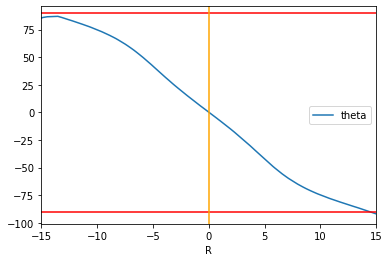

In [13]:
vp.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

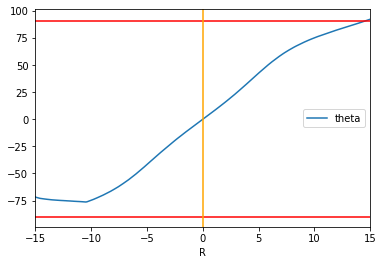

In [14]:
vn.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [15]:
vp_rp = vp[vp.R>0]
vp_rn = vp[vp.R<0]
vn_rp = vn[vn.R>0]
vn_rn = vn[vn.R<0]

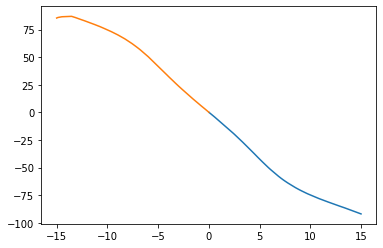

In [16]:
plt.plot(vp_rp.R, vp_rp.theta)
plt.plot(vp_rn.R, vp_rn.theta)

### Positive and Negative field discrepancy is <0.5$^\circ$ 

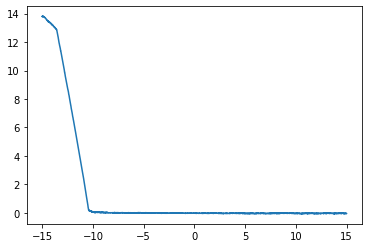

In [17]:
plt.plot(vp.R, (vp.theta+vn.theta))

### Positive voltage R-theta relation

In [18]:
vp_R_thetapos_coeff = np.polyfit(vp_rp.theta, vp_rp.R, 6)
vp_R_thetaneg_coeff = np.polyfit(vp_rn.theta, vp_rn.R, 6)
vp_R_thetapos = np.poly1d(vp_R_thetapos_coeff)
vp_R_thetaneg = np.poly1d(vp_R_thetaneg_coeff)
R_theta = vp_R_thetapos_coeff,vp_R_thetaneg_coeff
print(R_theta)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta, delimiter=",")

(array([-1.88875574e-10, -4.69977166e-08, -4.12744260e-06, -1.69582896e-04,
       -3.68481506e-03, -1.59453031e-01, -3.74949995e-02]), array([-2.00043896e-10,  4.72499202e-08, -4.47312714e-06,  1.97086483e-04,
       -3.61658550e-03, -1.03509122e-01, -3.55658911e-02]))


<Figure size 432x288 with 0 Axes>

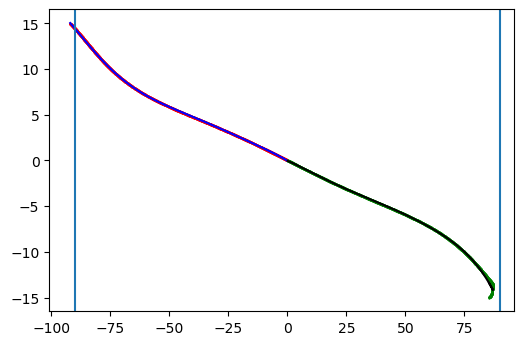

In [19]:
plt.figure(1)
plt.figure(dpi=100)
plt.plot(vp_rp.theta, vp_rp.R, 'r+', markersize=2)
plt.plot(vp_rp.theta, vp_R_thetapos(vp_rp.theta), 'b')
plt.plot(vp_rn.theta, vp_rn.R, 'g+', markersize=2)
plt.plot(vp_rn.theta, vp_R_thetaneg(vp_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

In [20]:
bmag_vp_rp_coeff = np.polyfit(vp[vp.R>0].R, vp[vp.R>0].Bmag, 10)
bmag_vp_rp = np.poly1d(bmag_vp_rp_coeff)

bmag_vp_rn_coeff = np.polyfit(vp[vp.R<0].R, vp[vp.R<0].Bmag, 10)
bmag_vp_rn = np.poly1d(bmag_vp_rn_coeff)

bmag_vn_rp_coeff = np.polyfit(vn[vn.R>0].R, vn[vn.R>0].Bmag, 10)
bmag_vn_rp = np.poly1d(bmag_vn_rp_coeff)

bmag_vn_rn_coeff = np.polyfit(vn[vn.R<0].R, vn[vn.R<0].Bmag, 10)
bmag_vn_rn = np.poly1d(bmag_vn_rn_coeff)

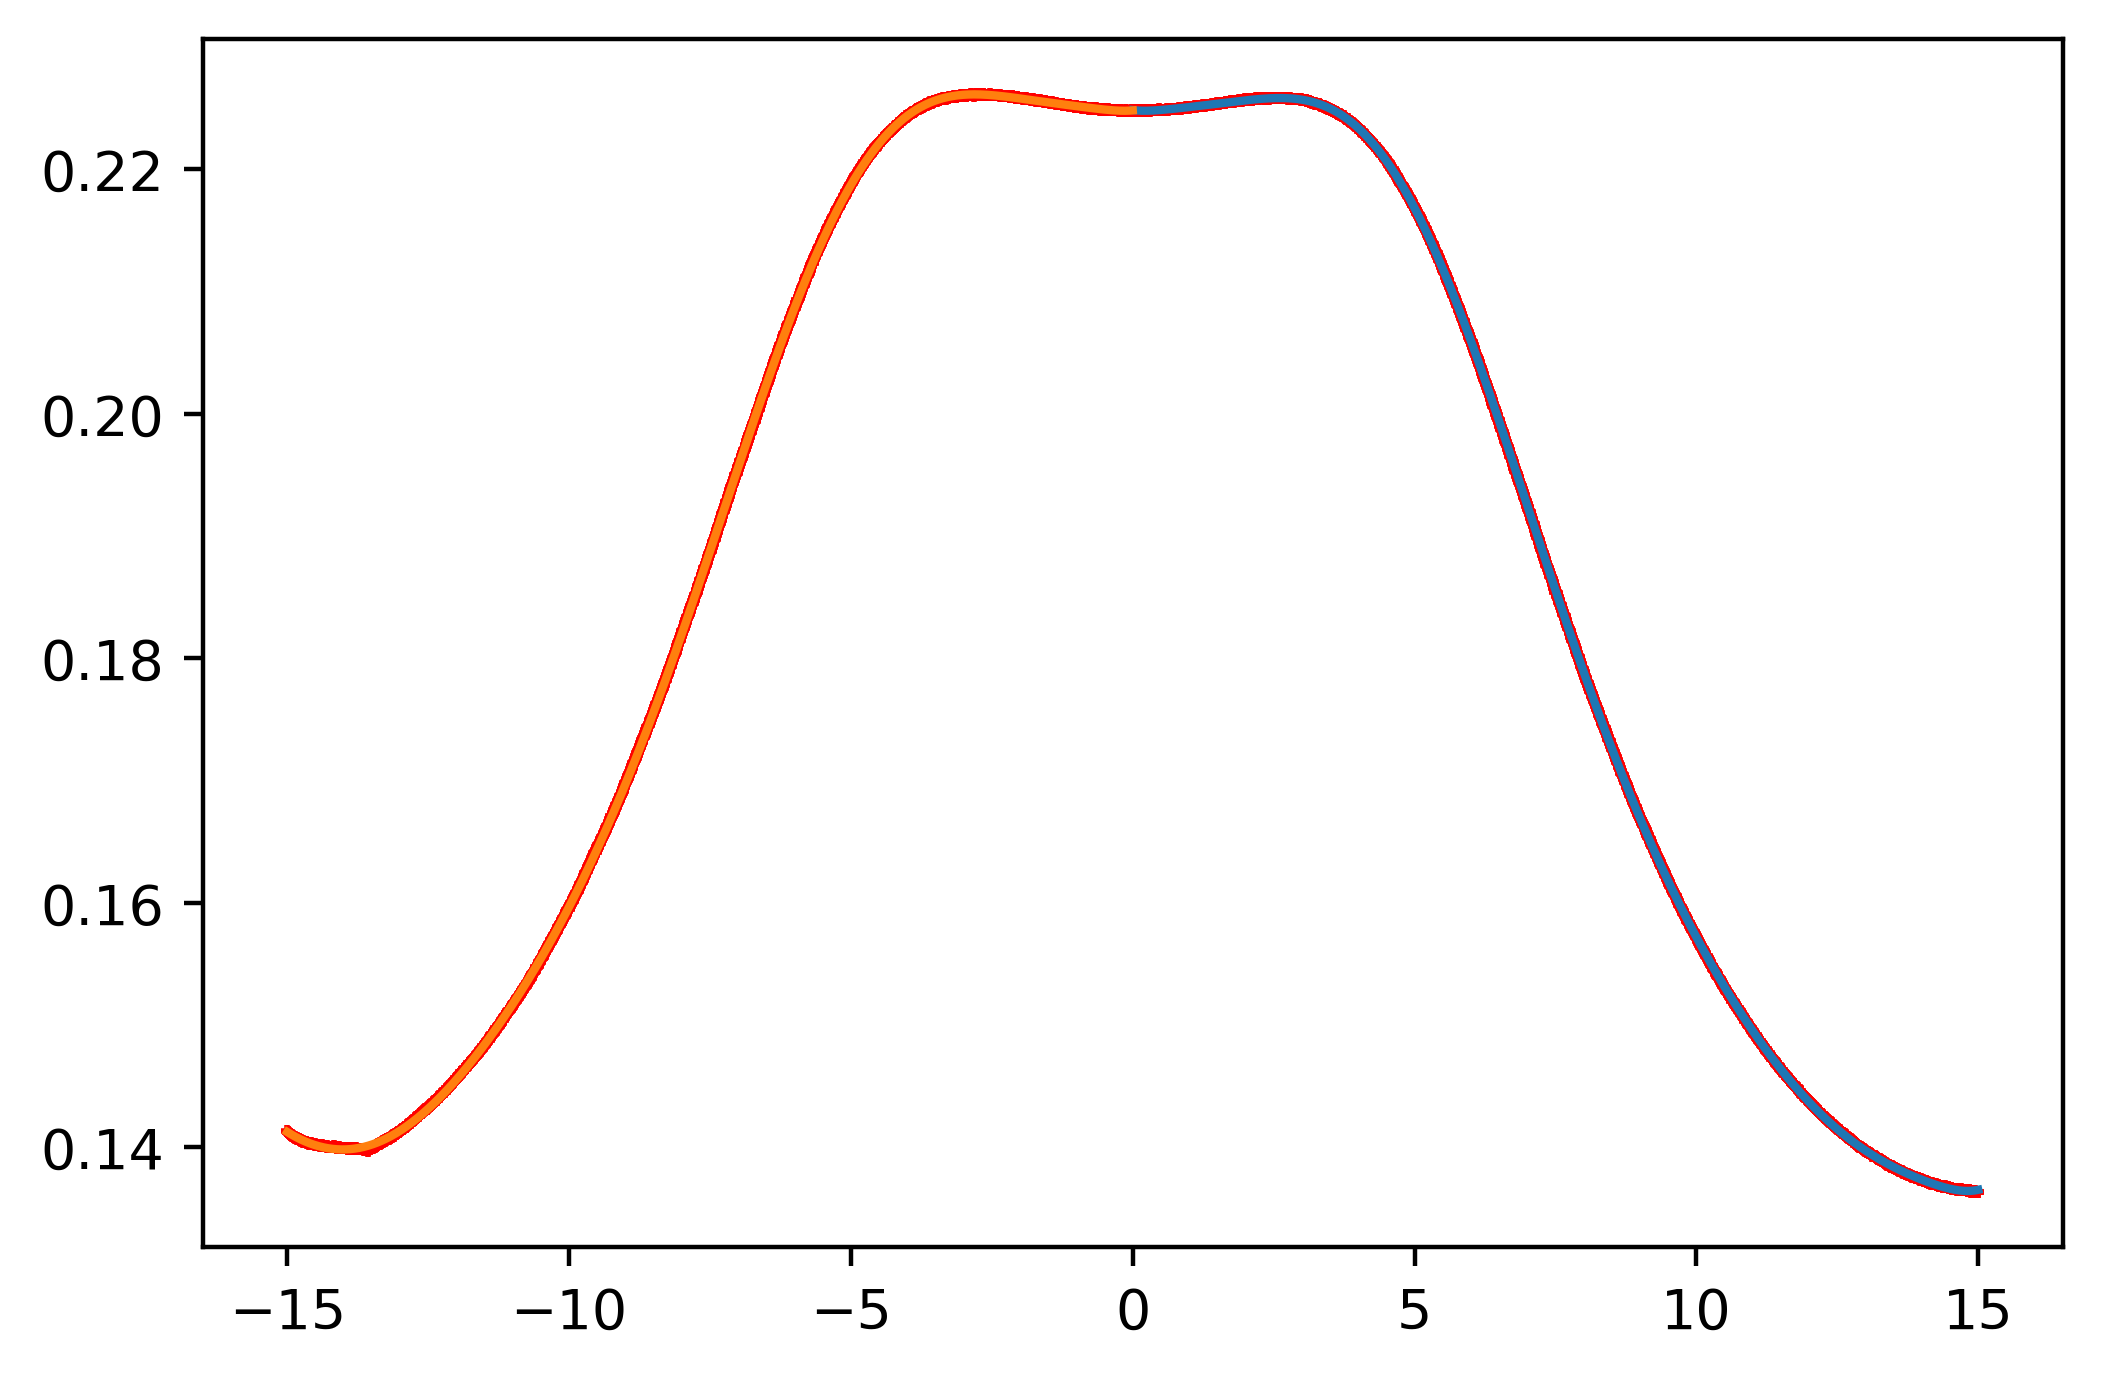

In [21]:
plt.figure(dpi=400)
plt.plot(vp.R, vp.Bmag, 'r+', markersize=2)
plt.plot(vp[vp.R>0].R, bmag_vp_rp(vp[vp.R>0].R))
plt.plot(vp[vp.R<0].R, bmag_vp_rn(vp[vp.R<0].R))
# plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
# plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
# plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

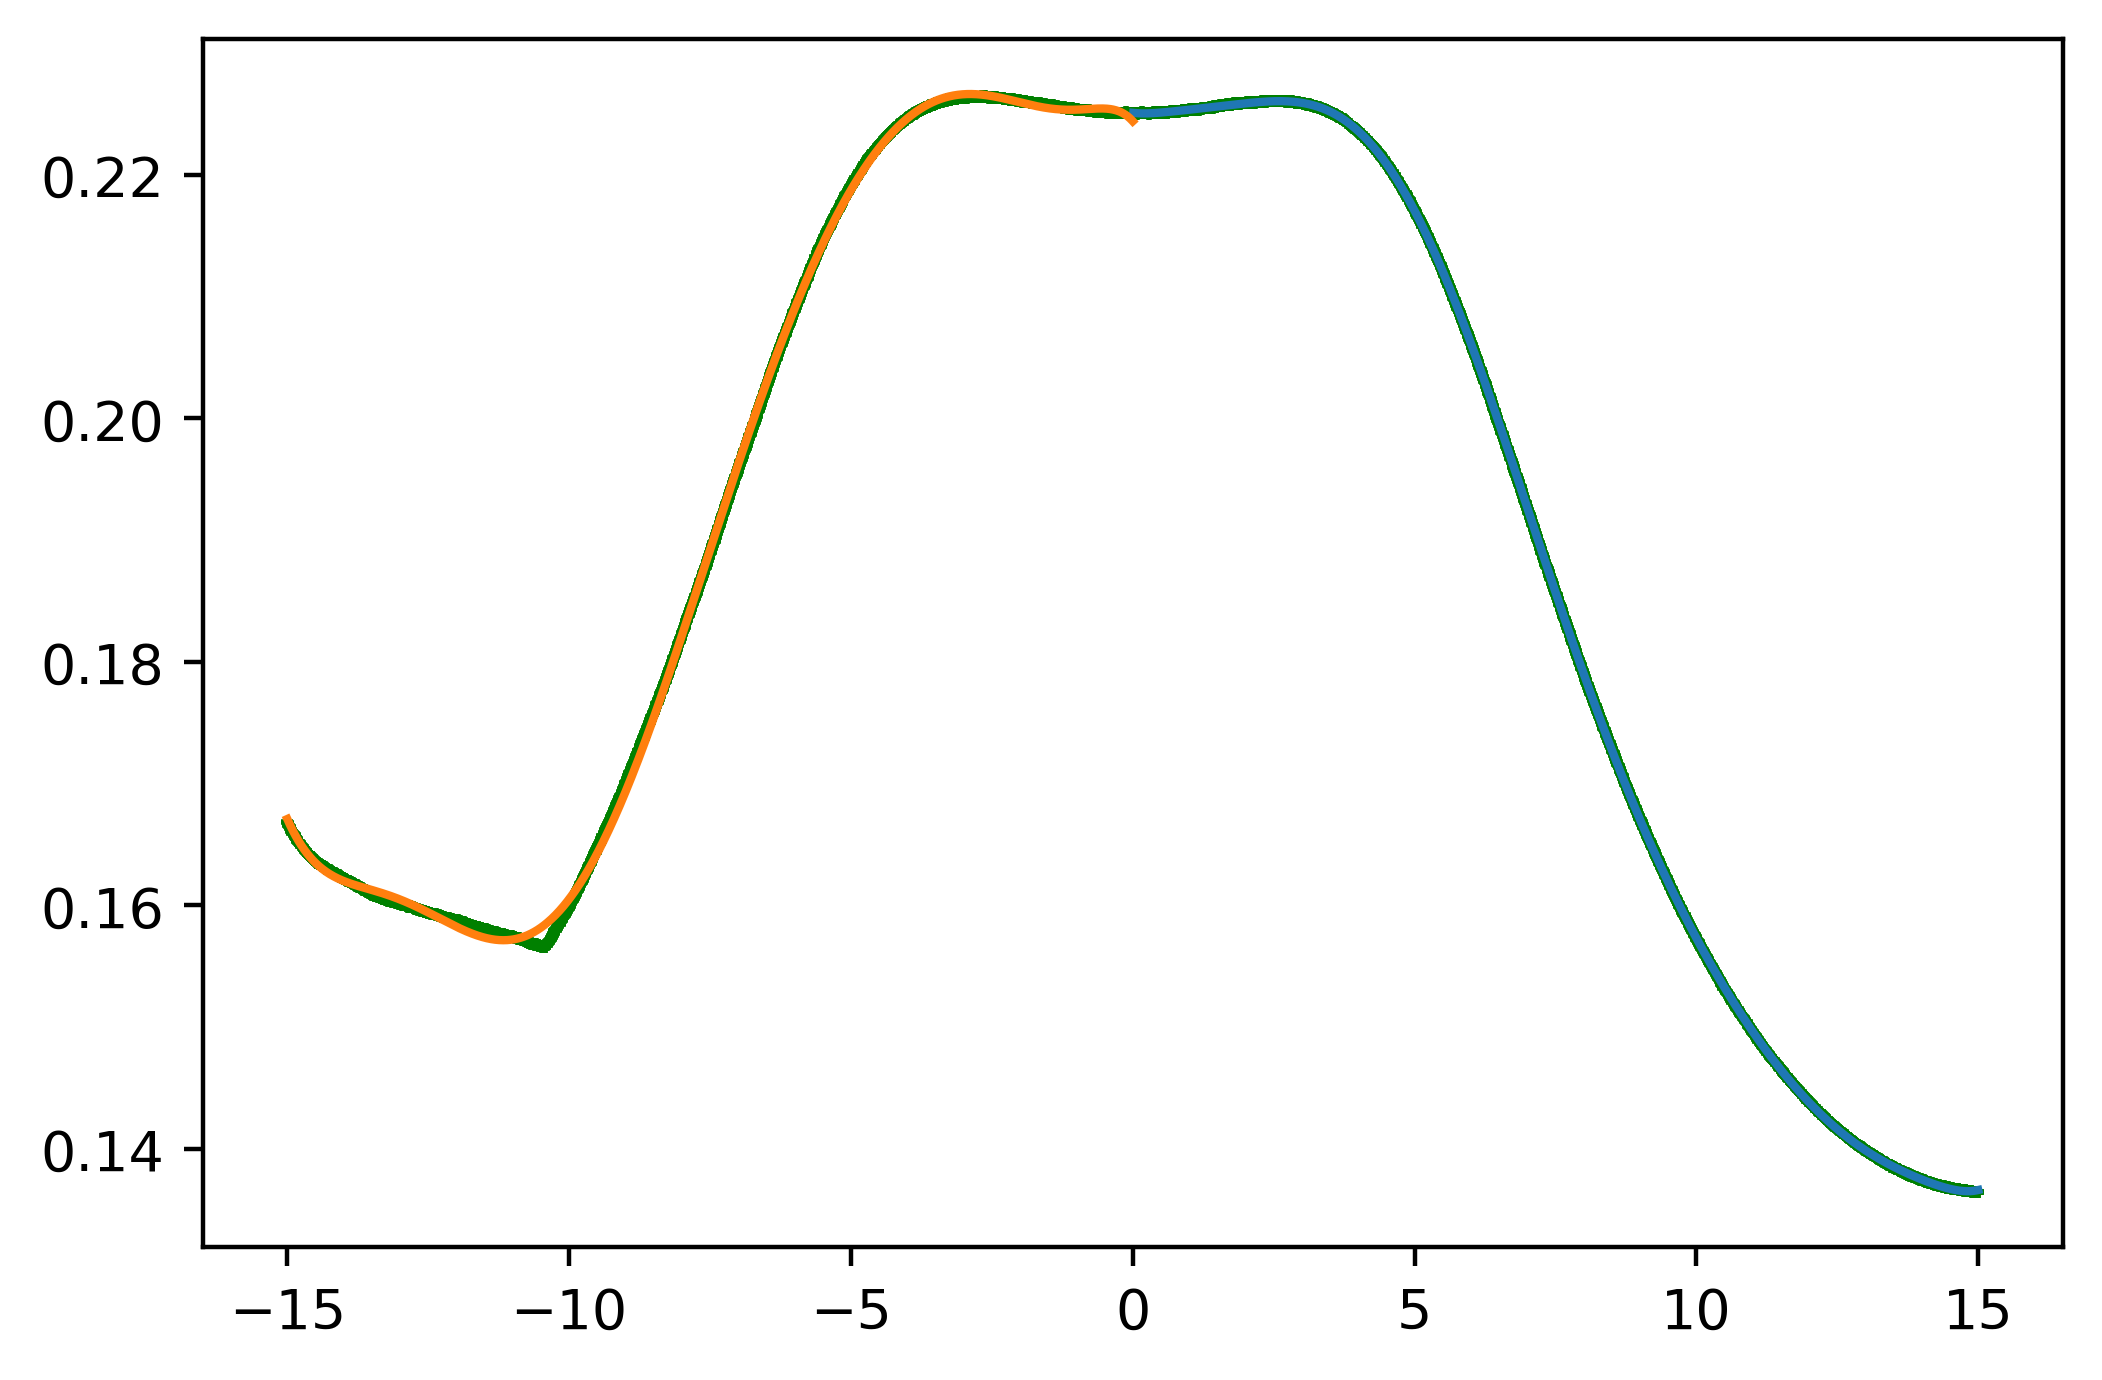

In [22]:
plt.figure(dpi=400)
plt.plot(vn.R, vn.Bmag, 'g+', markersize=2)
plt.plot(vn[vn.R>0].R, bmag_vn_rp(vn[vn.R>0].R))
plt.plot(vn[vn.R<0].R, bmag_vn_rn(vn[vn.R<0].R))

### Voltage Correction function

In [23]:
V0 = 5.0 # Voltage used for radial scan
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)

In [24]:
vcent_vp_rp = V0/cen_vp_fit(bmag_vp_rp(Rpts_p))
vcent_vp_rn = V0/cen_vp_fit(bmag_vp_rn(Rpts_n))
vcent_vn_rp = -V0/cen_vn_fit(-bmag_vn_rp(Rpts_p))
vcent_vn_rn = -V0/cen_vn_fit(-bmag_vn_rn(Rpts_n))

In [25]:
n = 10
vcorr_vp_rp_coeff = np.polyfit(Rpts_p, vcent_vp_rp, n)
vcorr_vp_rp = np.poly1d(vcorr_vp_rp_coeff)
vcorr_vp_rn_coeff = np.polyfit(Rpts_n, vcent_vp_rn, n)
vcorr_vp_rn = np.poly1d(vcorr_vp_rn_coeff)
vcorr_vn_rp_coeff = np.polyfit(Rpts_p, vcent_vn_rp, n)
vcorr_vn_rp = np.poly1d(vcorr_vn_rp_coeff)
vcorr_vn_rn_coeff = np.polyfit(Rpts_n, vcent_vn_rn, n)
vcorr_vn_rn = np.poly1d(vcorr_vn_rn_coeff)

In [26]:
print(vcorr_vp_rp_coeff, '\n', vcorr_vp_rn_coeff, '\n', vcorr_vn_rp_coeff, '\n',vcorr_vn_rn_coeff)

[ 1.06894022e-09 -8.40541456e-08  2.79124005e-06 -5.06102129e-05
  5.39946066e-04 -3.40463809e-03  1.23152179e-02 -2.59799884e-02
  3.07008049e-02 -1.30873530e-02 -1.05104199e+00] 
 [ 1.95410690e-10  2.27779784e-08  9.85154810e-07  2.15398435e-05
  2.61742239e-04  1.78324171e-03  6.58612452e-03  1.39295977e-02
  1.70230071e-02  5.71503251e-03 -1.05194789e+00] 
 [ 1.01373603e-09 -7.88460322e-08  2.58732724e-06 -4.63053763e-05
  4.86969179e-04 -3.02206764e-03  1.07330451e-02 -2.20833336e-02
  2.52822349e-02 -1.03276615e-02 -9.60383393e-01] 
 [-2.05639136e-09 -1.60403574e-07 -5.25605588e-06 -9.44932678e-05
 -1.02393150e-03 -6.92735823e-03 -2.90550953e-02 -7.02067005e-02
 -8.65131932e-02 -4.71602244e-02 -9.67360235e-01]


In [27]:
vcorr_coeffs = [vcorr_vp_rp_coeff, vcorr_vn_rp_coeff, vcorr_vp_rn_coeff, vcorr_vn_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

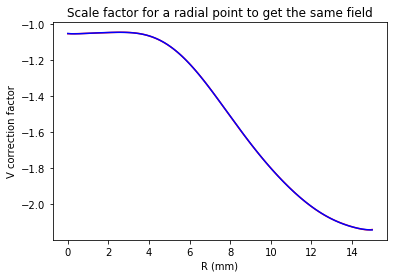

In [28]:
plt.plot(Rpts_p, vcent_vp_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

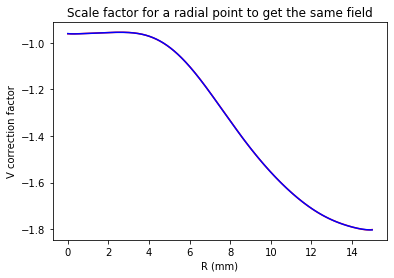

In [29]:
plt.plot(Rpts_p, vcent_vn_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

### 90 degrees

In [19]:
vp90 = pd.read_csv('./2019-06-28/5vp90_daedalus_radialPolar_calib_A090.0_2019-06-28_1.csv', comment='#')
vn90 = pd.read_csv('./2019-06-28/5vn90_daedalus_radialPolar_calib_A090.0_2019-06-28_1.csv', comment='#')

In [20]:
vp90 = vp90.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vp90 = vp90.assign(theta=lambda a: np.arctan2(a.Zfield, -a.Xfield)*180/np.pi)
vp90 = vp90.assign(Bmag=lambda a: np.sqrt(a.Xfield**2 + a.Zfield**2))

vn90 = vn90.assign(phi=lambda a: np.arctan2(a.Xfield, a.Yfield)*180/np.pi)
vn90 = vn90.assign(theta=lambda a: np.arctan2(a.Zfield, a.Xfield)*180/np.pi)
vn90 = vn90.assign(Bmag=lambda a: np.sqrt(a.Xfield**2 + a.Zfield**2))

vp90_dv = {}
vn90_dv = {}
for c in vp90.columns[:]:
    vp90_dv[c] = (["R"],vp90[c])
    vn90_dv[c] = (["R"],vn90[c])
vp90_ds = xr.Dataset(vp90_dv)
vn90_ds = xr.Dataset(vn90_dv)

In [21]:
vp90.plot('R', 'theta')
plt.axhline(90,color='r')
plt.axhline(-90,color='r')
plt.axvline(0,color='orange')

In [22]:
vn90.plot('R', 'theta')
plt.axhline(-90,color='r')
plt.axhline(90, color='r')
plt.axvline(0,color='orange')

In [23]:
vp90_rp = vp90[vp90.R>0]
vp90_rn = vp90[vp90.R<0]
vn90_rp = vn90[vn90.R>0]
vn90_rn = vn90[vn90.R<0]

In [24]:
plt.plot(vp90_rp.R, vp90_rp.theta)
plt.plot(vp90_rn.R, vp90_rn.theta)

### Plot pos neg voltage discrepancy

In [25]:
plt.plot(vp90.R, (vp90.theta+vn90.theta))

### Positive voltage R-theta relation

In [26]:
vp90_R_thetapos_coeff = np.polyfit(vp90_rp.theta, vp90_rp.R, 6)
vp90_R_thetaneg_coeff = np.polyfit(vp90_rn.theta, vp90_rn.R, 6)
vp90_R_thetapos = np.poly1d(vp90_R_thetapos_coeff)
vp90_R_thetaneg = np.poly1d(vp90_R_thetaneg_coeff)
R_theta90 = vp90_R_thetapos_coeff,vp90_R_thetaneg_coeff
print(R_theta90)
np.savetxt("./icarusCalibCsv/icarus_radial_polar_calib.csv", R_theta90, delimiter=",")

(array([-2.20038918e-10, -5.33665460e-08, -4.58855053e-06, -1.85556524e-04,
       -3.94442279e-03, -1.60119097e-01, -3.96000666e-02]), array([ 1.50421396e-10, -3.85333747e-08,  3.44453525e-06, -1.41754881e-04,
        3.08195442e-03, -1.56619357e-01,  6.04727391e-02]))


In [27]:
plt.figure(dpi=100)
plt.plot(vp90_rp.theta, vp90_rp.R, 'r+', markersize=2)
plt.plot(vp90_rp.theta, vp90_R_thetapos(vp90_rp.theta), 'b')
plt.plot(vp90_rn.theta, vp90_rn.R, 'g+', markersize=2)
plt.plot(vp90_rn.theta, vp90_R_thetaneg(vp90_rn.theta), 'k')
plt.axvline(90)
plt.axvline(-90)

### Difference between 0 and 90 fit

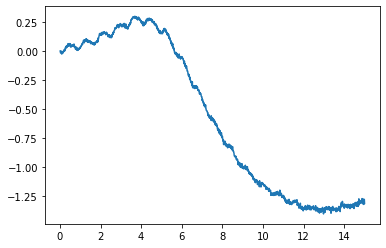

In [49]:
plt.plot(vp_rp.R, vp_rp.theta-vp90_rp.theta)

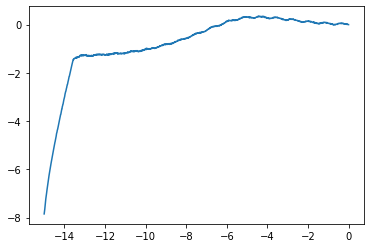

In [51]:
plt.plot(vp_rn.R, vp_rn.theta-vp90_rn.theta)

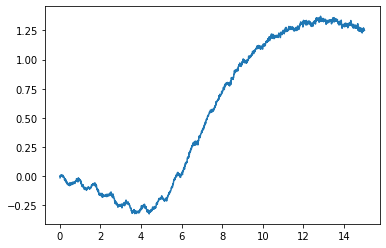

In [50]:
plt.plot(vn_rp.R, vn_rp.theta-vn90_rp.theta)

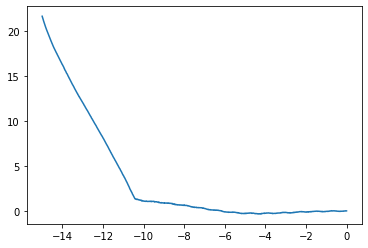

In [52]:
plt.plot(vn_rn.R, vn_rn.theta-vn90_rn.theta)

### Bmag

In [28]:
bmag_vp90_rp_coeff = np.polyfit(vp90[vp90.R>0].R, vp90[vp90.R>0].Bmag, 10)
bmag_vp90_rp = np.poly1d(bmag_vp90_rp_coeff)

bmag_vp90_rn_coeff = np.polyfit(vp90[vp90.R<0].R, vp90[vp90.R<0].Bmag, 10)
bmag_vp90_rn = np.poly1d(bmag_vp90_rn_coeff)

bmag_vn90_rp_coeff = np.polyfit(vn90[vn90.R>0].R, vn90[vn90.R>0].Bmag, 10)
bmag_vn90_rp = np.poly1d(bmag_vn90_rp_coeff)

bmag_vn90_rn_coeff = np.polyfit(vn90[vn90.R<0].R, vn90[vn90.R<0].Bmag, 10)
bmag_vn90_rn = np.poly1d(bmag_vn90_rn_coeff)

In [96]:
plt.figure(dpi=200)
plt.plot(vp90.R, vp90.Bmag, 'r+', markersize=2)
plt.plot(vp90[vp90.R>0].R, bmag_vp90_rp(vp90[vp90.R>0].R))
plt.plot(vp90[vp90.R<0].R, bmag_vp90_rn(vp90[vp90.R<0].R))

In [97]:
plt.figure(dpi=200)
plt.plot(vn90.R, vn90.Bmag, 'g+', markersize=2)
plt.plot(vn90[vn90.R>0].R, bmag_vn90_rp(vn90[vn90.R>0].R))
plt.plot(vn90[vn90.R<0].R, bmag_vn90_rn(vn90[vn90.R<0].R))

### Voltage Correction function

In [104]:
Rpts_p = np.arange(0, 15, 0.01)
Rpts_n = np.arange(-15, 0, 0.01)
vp0 = cen_vp_fit(bmag_vp90_rp(0.0))
vn0 = cen_vn_fit(-bmag_vn90_rp(0.0))

In [105]:
vcent_vp90_rp = vp0/cen_vp_fit(bmag_vp90_rp(Rpts_p))
vcent_vp90_rn = vp0/cen_vp_fit(bmag_vp90_rn(Rpts_n))
vcent_vn90_rp = vn0/cen_vn_fit(-bmag_vn90_rp(Rpts_p))
vcent_vn90_rn = vn0/cen_vn_fit(-bmag_vn90_rn(Rpts_n))

In [106]:
print(vcent_vp90_rp, vcent_vp90_rn, vcent_vn90_rp, vcent_vn90_rn)

[1.         0.99993916 0.99987838 ... 2.03850084 2.03827664 2.03803979] [2.01309067 2.01306152 2.01302488 ... 0.998334   0.99821006 0.99808052] [1.         0.99996636 0.99993203 ... 1.87672303 1.87654465 1.87635615] [1.85732098 1.8572883  1.85725007 ... 0.99888775 0.99878214 0.99867172]


In [107]:
n = 10
vcorr_vp90_rp_coeff = np.polyfit(Rpts_p, vcent_vp90_rp, n)
vcorr_vp90_rp = np.poly1d(vcorr_vp90_rp_coeff)
vcorr_vp90_rn_coeff = np.polyfit(Rpts_n, vcent_vp90_rn, n)
vcorr_vp90_rn = np.poly1d(vcorr_vp90_rn_coeff)
vcorr_vn90_rp_coeff = np.polyfit(Rpts_p, vcent_vn90_rp, n)
vcorr_vn90_rp = np.poly1d(vcorr_vn90_rp_coeff)
vcorr_vn90_rn_coeff = np.polyfit(Rpts_n, vcent_vn90_rn, n)
vcorr_vn90_rn = np.poly1d(vcorr_vn90_rn_coeff)

In [114]:
vcorr_vp90_rp_coeff

array([-1.06431712e-09,  8.15398480e-08, -2.62857588e-06,  4.60249025e-05,
       -4.70244011e-04,  2.79949498e-03, -9.34895293e-03,  1.81185915e-02,
       -1.92636710e-02,  4.14166248e-03,  9.98738221e-01])

In [108]:
print(vcorr_vp90_rp_coeff, '\n', vcorr_vp90_rn_coeff, '\n', vcorr_vn90_rp_coeff, '\n',vcorr_vn90_rn_coeff)

[-1.06431712e-09  8.15398480e-08 -2.62857588e-06  4.60249025e-05
 -4.70244011e-04  2.79949498e-03 -9.34895293e-03  1.81185915e-02
 -1.92636710e-02  4.14166248e-03  9.98738221e-01] 
 [-6.09695197e-10 -5.15955581e-08 -1.84448105e-06 -3.60215055e-05
 -4.14236604e-04 -2.81744795e-03 -1.09697219e-02 -2.44520096e-02
 -3.02802018e-02 -1.50941687e-02  9.97691305e-01] 
 [-1.05587516e-09  8.05390282e-08 -2.58323973e-06  4.49734655e-05
 -4.56744434e-04  2.70594332e-03 -9.03856147e-03  1.76504886e-02
 -1.91278028e-02  4.70102221e-03  9.99021745e-01] 
 [-6.59630873e-10 -5.48419174e-08 -1.92524413e-06 -3.68993439e-05
 -4.16146023e-04 -2.77395917e-03 -1.05751180e-02 -2.30018789e-02
 -2.78356862e-02 -1.36887624e-02  9.98251071e-01]


In [109]:
vcorr_coeffs = [vcorr_vp90_rp_coeff, vcorr_vn90_rp_coeff, vcorr_vp90_rn_coeff, vcorr_vn90_rn_coeff]
np.savetxt("./icarusCalibCsv/icarus_volt_correction_calib.csv", vcorr_coeffs, delimiter=",")

In [112]:
plt.plot(Rpts_p, vcent_vp90_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vp90_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

In [113]:
plt.plot(Rpts_p, vcent_vn90_rp, 'r', markersize = 2)
plt.plot(Rpts_p, vcorr_vn90_rp(Rpts_p), 'b')
plt.xlabel('R (mm)')
plt.ylabel('V correction factor')
plt.title('Scale factor for a radial point to get the same field')

Text(0.5, 1.0, 'Scale factor for a radial point to get the same field')

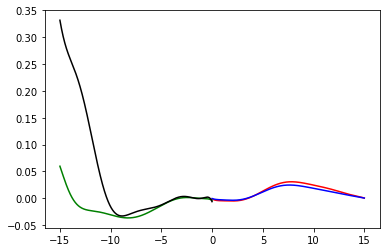

In [68]:
plt.plot(Rpts_p, vcent_vp_rp-vcent_vp90_rp, 'r')
plt.plot(Rpts_p, vcent_vn_rp-vcent_vn90_rp, 'b')
plt.plot(Rpts_n, vcent_vp_rn-vcent_vp90_rn, 'g')
plt.plot(Rpts_n, vcent_vn_rn-vcent_vn90_rn, 'k')